In [5]:
# Imports all the required packages
import evals
import os
import argparse
import numpy as np
import os.path as osp
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.data import (InMemoryDataset, download_url, extract_zip,Data)

import torch
#from torcheval.metrics import R2Score # To be implemented
import torch.nn as nn
import torch.nn.functional as F
from rdkit.Chem import DataStructs
from torch_geometric.loader import DataLoader

import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.optim as optim
from torch_geometric.nn import GCNConv,GraphConv,NNConv
from torch_geometric.nn import global_add_pool,knn_graph

try:
    import rdkit
    from rdkit import Chem
    from rdkit.Chem import AllChem
    from rdkit import rdBase
    from rdkit.Chem.rdchem import HybridizationType
    from rdkit import RDConfig
    from rdkit.Chem import ChemicalFeatures
    from rdkit.Chem.rdchem import BondType as BT
    from rdkit.Chem import Draw
    rdBase.DisableLog('rdApp.error')
except ImportError:
    print("rdkit = None")

### Dataset

### Layer Models
1. GNN (or GCN Layer)
2. Flatten (`torch.nn.flatten`)
2. VAE (c-gm-vae)

In [6]:
# GNN Model

# Model definition used for regression

class GCNlayer(nn.Module):
    
    def __init__(self, n_features, conv_dims, concat_dim, dropout):
        super(GCNlayer, self).__init__()
        self.n_features = n_features
        self.conv_dims = conv_dims
        self.concat_dim =  concat_dim
        self.dropout = dropout
        
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.gru=nn.ModuleList()
        #args.conv_dims=[args.n_features,128,512,4092]
        self.lin0 = torch.nn.Linear(args.n_features, self.conv_dims[0]) # Changed from 128
        for i in range(len(self.conv_dims)-1):
            kk = nn.Sequential(Linear(6, self.conv_dims[i+1]), nn.ReLU(), Linear(self.conv_dims[i+1], self.conv_dims[i+1]*self.conv_dims[i+1]))
            conv = NNConv(self.conv_dims[i], self.conv_dims[i+1],kk,aggr='add')
            self.convs.append(conv)
            bn = BatchNorm1d(self.conv_dims[i+1])
            self.bns.append(bn)
            self.gru.append(nn.GRU(self.conv_dims[i+1], self.conv_dims[i+1])) # Changed
        self.conv_last = GraphConv(self.conv_dims[-1],self.conv_dims[-1])  # Last layer
        self.bn_last = BatchNorm1d(self.concat_dim)
    '''
    def forward(self, data):
        x, edge_index,edge_attr= data.x, data.edge_index,data.edge_attr # Changed . added edge_attr
        out = F.relu(self.lin0(x))
        h = out.unsqueeze(0)
        for i in range(len(self.convs)):
            m = F.relu(self.convs[i](out, edge_index,edge_attr)) # Changed . added edge_attr
            m = self.bns[i](m)
            out, h = self.gru[i](m.unsqueeze(0), h)  # Changed here. Added [i]
            out = out.squeeze(0)

        x = F.relu(self.conv_last(out, edge_index))# Changed . added edge_attr
        x = self.bn_last(x)
        x = global_add_pool(x,batch=data.batch)   #global_add_pool  cHANGED
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x
    '''
    def forward(self, data):
        x, edge_index,edge_attr= data.x, data.edge_index,data.edge_attr # Changed . added edge_attr
        out = F.relu(self.lin0(x))
        temp=0
        h = out.unsqueeze(0)
        for i in range(len(self.convs)):
            if i%2==0:
               m = F.relu(self.convs[i](out+temp, edge_index,edge_attr)) # Changed . added edge_attr
               temp=out # Changed
            else:
               m = F.relu(self.convs[i](out, edge_index,edge_attr))
            m = self.bns[i](m)
            out, h = self.gru[i](m.unsqueeze(0), h)  # Changed here. Added [i]
            out = out.squeeze(0)

        x = F.relu(self.conv_last(out, edge_index))# Changed . added edge_attr
        x = self.bn_last(x)
        x = global_add_pool(x,batch=data.batch)   #global_add_pool  cHANGED
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x
    
class FClayer(nn.Module):
    
    def __init__(self, concat_dim, pred_dims, out_dim, dropout):
        super(FClayer, self).__init__()
        self.concat_dim = concat_dim
        self.pred_dims = pred_dims
        self.out_dim = out_dim
        self.dropout = dropout

        self.fcs = nn.ModuleList()
        self.bns = nn.ModuleList()
        # Linear layer has bias default=True
        for i in range(len(self.pred_dims)-1):
            fc = Linear(self.pred_dims[i], self.pred_dims[i+1])
            self.fcs.append(fc)
            bn = BatchNorm1d(self.pred_dims[i+1])
            self.bns.append(bn)
        self.fc_last = Linear(self.pred_dims[-1], self.out_dim)
    
    def forward(self, data):
        x = data
        for i in range(len(self.fcs)):
            x = F.relu(self.fcs[i](x))
            x = self.bns[i](x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc_last(x)
        return x

# Model definition  
class GCN_Model_reg(nn.Module):
    def __init__(self, args):
        super(GCN_Model_reg, self).__init__()
        
        # Convolutional Layer call
        self.conv = GCNlayer(args.n_features,args.conv_dims,args.concat_dim,args.dropout)

        # Fully connected layer call
        self.fc = FClayer(args.concat_dim,args.pred_dims,args.out_dim,args.dropout)
        
    def forward(self, data):
        x = self.conv(data) # Calling the convolutional layercpu
        x = self.fc(x) # Calling the Fully Connected Layer
        return x

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import log_normal, log_normal_mixture


device = torch.device( "cuda") #"cuda:0" if torch.cuda.is_available() else

class base_class(nn.Module):
    def __init__(self,args):
        super(base_class, self).__init__()
        self.args=args
        self.model=GCN_Model_reg(self.args) #weights='ResNet101_Weights.IMAGENET1K_V1'
        #self.model.fc=nn.Flatten() # Flatten the last layer
        print(self.model)
    def forward(self,data):
        return self.model(data)

class VAE(nn.Module):
    def __init__(self, args):
        super(VAE, self).__init__()
        self.args = args
        self.dropout = nn.Dropout(p=args.drop)

        self.base_model=base_class(args)
        
        """Feature encoder"""
        self.fx = nn.Sequential(
            nn.Linear(args.feature_dim, 256), # Set args.feature dim according to flatten shape. By default it is 2048
            nn.ReLU(),
            self.dropout,
            nn.Linear(256, 512,bias=True),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, 512,bias=True),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, 256,bias=True),
            nn.ReLU(),
            self.dropout
        )
        self.fx_mu = nn.Linear(256, args.latent_dim,bias=True)
        self.fx_logvar = nn.Linear(256, args.latent_dim,bias=True)

        """Label encoder"""
        self.label_lookup = nn.Linear(args.label_dim, args.emb_size)
        self.fe = nn.Sequential(
            nn.Linear(args.emb_size, 512,bias=True),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, 256,bias=True),
            nn.ReLU(),
            self.dropout
        )
        self.fe_mu = nn.Linear(256, args.latent_dim,bias=True)
        self.fe_logvar = nn.Linear(256, args.latent_dim,bias=True)

        """Decoder"""
        self.fd = nn.Sequential(
            nn.Linear(args.feature_dim + args.latent_dim, 512,bias=True),
            nn.ReLU(),
            nn.Linear(512, args.emb_size,bias=True),
            nn.LeakyReLU()
        )

    def label_encode(self, x):
        h0 = self.dropout(F.relu(self.label_lookup(x)))
        h = self.fe(h0)
        mu = self.fe_mu(h)
        logvar = self.fe_logvar(h)
        fe_output = {
            'fe_mu': mu,
            'fe_logvar': logvar
        }
        return fe_output

    def feat_encode(self, x):
        #print(x.shape)
        h = self.fx(x)
        mu = self.fx_mu(h)
        logvar = self.fx_logvar(h)
        fx_output = {
            'fx_mu': mu,
            'fx_logvar': logvar
        }
        return fx_output

    def decode(self, z):
        d = self.fd(z)
        d = F.normalize(d, dim=1)
        return d

    def label_forward(self, x, feat):
        n_label = x.shape[1]
        all_labels = torch.eye(n_label).to(device)
        fe_output = self.label_encode(all_labels)
        mu = fe_output['fe_mu']
        
        z = torch.matmul(x, mu) / x.sum(1, keepdim=True)
        #print(feat.shape,z.shape)
        label_emb = self.decode(torch.cat((feat, z), 1))

        fe_output['label_emb'] = label_emb
        return fe_output

    def feat_forward(self, x):
        fx_output = self.feat_encode(x)
        mu = fx_output['fx_mu']
        logvar = fx_output['fx_logvar']

        if not self.training:
            z = mu
            z2 = mu
        else:
            z = reparameterize(mu, logvar)
            z2 = reparameterize(mu, logvar)
        feat_emb = self.decode(torch.cat((x, z), 1))
        feat_emb2 = self.decode(torch.cat((x, z2), 1))
        fx_output['feat_emb'] = feat_emb
        fx_output['feat_emb2'] = feat_emb2
        return fx_output

    def forward(self, label, feature):
        # Apply resnet model to get feature embeddings
        feature=self.base_model(feature)
        fe_output = self.label_forward(label, feature)
        label_emb = fe_output['label_emb']
        fx_output = self.feat_forward(feature)
        feat_emb, feat_emb2 = fx_output['feat_emb'], fx_output['feat_emb2']

        embs = self.label_lookup.weight
        label_out = torch.matmul(label_emb, embs)
        feat_out = torch.matmul(feat_emb, embs)
        feat_out2 = torch.matmul(feat_emb2, embs)
        
        fe_output.update(fx_output)
        output = fe_output
        output['embs'] = embs
        output['label_out'] = label_out
        output['feat_out'] = feat_out
        output['feat_out2'] = feat_out2
        output['feat'] = feature
        return output


def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std


def compute_loss(input_label, output, args=None):
    fe_out, fe_mu, fe_logvar, label_emb = \
        output['label_out'], output['fe_mu'], output['fe_logvar'], output['label_emb']
    fx_out, fx_mu, fx_logvar, feat_emb = \
        output['feat_out'], output['fx_mu'], output['fx_logvar'], output['feat_emb']
    fx_out2 = output['feat_out2']
    embs = output['embs']

    fx_sample = reparameterize(fx_mu, fx_logvar)
    fx_var = torch.exp(fx_logvar)
    fe_var = torch.exp(fe_logvar)
    kl_loss = (log_normal(fx_sample, fx_mu, fx_var) - \
        log_normal_mixture(fx_sample, fe_mu, fe_var, input_label)).mean()

    pred_e = torch.sigmoid(fe_out)
    pred_x = torch.sigmoid(fx_out)
    pred_x2 = torch.sigmoid(fx_out2)

    def compute_BCE_and_RL_loss(E):
        #compute negative log likelihood (BCE loss) for each sample point
        sample_nll = -(
            torch.log(E) * input_label + torch.log(1 - E) * (1 - input_label)
        )
        logprob = -torch.sum(sample_nll, dim=2)

        #the following computation is designed to avoid the float overflow (log_sum_exp trick)
        maxlogprob = torch.max(logprob, dim=0)[0]
        Eprob = torch.mean(torch.exp(logprob - maxlogprob), axis=0)
        nll_loss = torch.mean(-torch.log(Eprob) - maxlogprob)
        return nll_loss

    def supconloss(label_emb, feat_emb, embs, temp=1.0):
        features = torch.cat((label_emb, feat_emb))
        labels = torch.cat((input_label, input_label)).float()
        n_label = labels.shape[1]
        emb_labels = torch.eye(n_label).to(device)
        mask = torch.matmul(labels, emb_labels)

        anchor_dot_contrast = torch.div(
            torch.matmul(features, embs),
            temp)
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        exp_logits = torch.exp(logits)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        loss = -mean_log_prob_pos
        loss = loss.mean()
        return loss

    nll_loss = compute_BCE_and_RL_loss(pred_e.unsqueeze(0))
    nll_loss_x = compute_BCE_and_RL_loss(pred_x.unsqueeze(0))
    nll_loss_x2 = compute_BCE_and_RL_loss(pred_x2.unsqueeze(0))
    sum_nll_loss = nll_loss + nll_loss_x + nll_loss_x2
    cpc_loss = supconloss(label_emb, feat_emb, embs)
    total_loss = sum_nll_loss * args.nll_coeff + kl_loss * 6. + cpc_loss
    return total_loss, nll_loss, nll_loss_x, 0., 0., kl_loss, cpc_loss, pred_e, pred_x


In [8]:
# pytorch will be run on cpu
seed= 500 #200
paser = argparse.ArgumentParser()
args = paser.parse_args("")
np.random.seed(seed)
torch.manual_seed(seed)
device=input("Enter cuda or cpu for device type")
device = torch.device(device)
#'cuda' if torch.cuda.is_available() else
device

device(type='cuda')

In [9]:
# Inputs required by the program
args.epoch = 10
args.lr = 0.005
args.optim = 'Adam'
args.step_size = 25
args.gamma = 0.8
args.dropout = 0 # Tested for 0.2 but max r2 got 0.874. For 0.1 I got 0.897
args.n_features = 87  # Mass added else 29. Without atomic mass r2 0.899
args.concat_dim=128
args.conv_dims=[128,128,128,128] # Removed 1 layer
args.pred_dims=[128]
args.out_dim = 256

In [10]:
# Importing Dataset
import pandas as pd

dataset = pd.read_csv('../Dataset/sider.csv', low_memory=False)
#dataset=dataset.drop(['mol_id'],axis=1)
# dataset.fillna(0, inplace=True)
df = dataset.drop(["smiles"], axis = 1)
#df.fillna(0,inplace=True)
dfcols = df.columns
#df['New_Column'] = (df == 0).all(axis=1).astype(int)
dataset['labels'] = df.apply(lambda row: row.astype(int).tolist(), axis=1)
dataset.drop(list(dfcols), axis = 1, inplace=True)
print(len(dataset))
num_labels = len(dataset["labels"].iloc[0])

1427


In [11]:
# Check for NaN values in the entire DataFrame
nan_values = df.isna().sum()

# Print the columns with NaN values and their counts
print("Columns with NaN values:")
print(nan_values[nan_values > 0])

Columns with NaN values:
Series([], dtype: int64)


In [12]:

# Device 
args.device = torch.device("cuda") #"cuda:0" if torch.cuda.is_available() else 
print(args.device)

# Dataset name
args.dataset='sider'

# General Model variables
args.seed=seed
args.lr=1e-3
args.lr_decay_ratio=0.9
args.lr_decay_times=4
args.nll_coeff=0.5
args.l2_coeff=1
args.c_coeff=0
args.class_weights=1  # Find the class weights depending on count
args.current_step=0 # For Plotting the loss and other variables w.r.t iterations

# Set Dataloader parameters
args.BATCH_SIZE = 64
args.NUM_WORKERS = 8
args.max_epoch=200

# scheduler variables
args.eta_min=2e-4
args.T_mult=2
args.T0=50
args.retrain=input("Enter True or False if you want to retrain")=='True'

# VAE model variables
args.latent_dim=80
args.drop=0.1 # dropout value
args.feature_dim=256 # Output dimension from flattened ResNet
args.emb_size=80 # What is emb_size ?
args.label_dim=num_labels # Label Dimension
args.param_setting = "lr-{}_lr-decay_{:.2f}_lr-times_{:.1f}_nll-{:.2f}_l2-{:.2f}_c-{:.2f}".format(args.lr, args.lr_decay_ratio, args.lr_decay_times, args.nll_coeff, args.l2_coeff, args.c_coeff)

# Directory variables
args.summary_dir = 'summary/{}/{}'.format(args.dataset, args.param_setting)
args.model_dir = 'model/model_{}/{}'.format(args.dataset, args.param_setting)
args.checkpoint_path=''

cuda


In [13]:
import torch
import torch.nn as nn

# Assuming you have the GCN_Model_reg and VAE classes defined already

# Create instances of each layer
#gcn_layer = GCN_Model_reg(args)  # Assuming 'args' is defined appropriately
#flatten_layer = nn.Flatten()
#vae_layer = VAE(args)  # Assuming 'args' is defined appropriately

# Define the sequential model
'''
model = nn.Sequential(
    gcn_layer,
    flatten_layer,
    vae_layer
)
'''
model=VAE(args)


GCN_Model_reg(
  (conv): GCNlayer(
    (convs): ModuleList(
      (0-2): 3 x NNConv(128, 128, aggr=add, nn=Sequential(
        (0): Linear(in_features=6, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=16384, bias=True)
      ))
    )
    (bns): ModuleList(
      (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (gru): ModuleList(
      (0-2): 3 x GRU(128, 128)
    )
    (lin0): Linear(in_features=87, out_features=128, bias=True)
    (conv_last): GraphConv(128, 128)
    (bn_last): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): FClayer(
    (fcs): ModuleList()
    (bns): ModuleList()
    (fc_last): Linear(in_features=128, out_features=256, bias=True)
  )
)


In [14]:
print(model)

VAE(
  (dropout): Dropout(p=0.1, inplace=False)
  (base_model): base_class(
    (model): GCN_Model_reg(
      (conv): GCNlayer(
        (convs): ModuleList(
          (0-2): 3 x NNConv(128, 128, aggr=add, nn=Sequential(
            (0): Linear(in_features=6, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=16384, bias=True)
          ))
        )
        (bns): ModuleList(
          (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (gru): ModuleList(
          (0-2): 3 x GRU(128, 128)
        )
        (lin0): Linear(in_features=87, out_features=128, bias=True)
        (conv_last): GraphConv(128, 128)
        (bn_last): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (fc): FClayer(
        (fcs): ModuleList()
        (bns): ModuleList()
        (fc_last): Linear(in_features=128, out_features=256, bias=True)
      )
    )
  

In [15]:
m=GCN_Model_reg(args)
print(m)

GCN_Model_reg(
  (conv): GCNlayer(
    (convs): ModuleList(
      (0-2): 3 x NNConv(128, 128, aggr=add, nn=Sequential(
        (0): Linear(in_features=6, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=16384, bias=True)
      ))
    )
    (bns): ModuleList(
      (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (gru): ModuleList(
      (0-2): 3 x GRU(128, 128)
    )
    (lin0): Linear(in_features=87, out_features=128, bias=True)
    (conv_last): GraphConv(128, 128)
    (bn_last): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): FClayer(
    (fcs): ModuleList()
    (bns): ModuleList()
    (fc_last): Linear(in_features=128, out_features=256, bias=True)
  )
)


### GNN functions

In [16]:
# encoding of all variables

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
 
def get_intervals(l):
    """For list of lists, gets the cumulative products of the lengths"""
    intervals = len(l) * [0]
    # Initalize with 1
    intervals[0] = 1
    for k in range(1, len(l)):
        intervals[k] = (len(l[k]) + 1) * intervals[k - 1]
    return intervals

def safe_index(l, e):
    """Gets the index of e in l, providing an index of len(l) if not found"""
    try:
        return l.index(e)
    except:
        print("Add value to list of length {}".format(len(l)))
        return len(l)

In [17]:
# Atom features

#possible_atom_list = ['H','C', 'O', 'F','N','Cl','P','S','Si','Br','I']  # Atomic symbol 1

possible_atom_list = [
    "He",'H',
    "Li", "Be", "B", "C", "N", "O", "F", "Ne",
    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar",
    "K", "Ca", 
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr",
    "Rb", "Sr", 
    "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe",
    "Cs", "Ba"
]


# possible_atom_list = ['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','K','Ar','Ca','Sc','Ti','V','Cr','Mn','Fe','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm','Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Nh','Fl','Mc','Lv','Ts','Og']  # Atomic symbol 117

aromatic=[0,1] # Aromatic 1
isring=[0,1]   # Ring 1
possible_numH_list = [0, 1, 2, 3, 4,5,6,7,8] # Total Number of bonded hydrogen atoms possible 5
num_bonds = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Total Number of Hs a carbon can bond / Total number of bonds an atom make 6
possible_formal_charge_list = [-5,-4,-3, -2, -1, 0, 1, 2, 3, 4, 5]

# sp3d is removed because it doesnot vary according to the paper . Hybridization 4
possible_hybridization_list = [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,Chem.rdchem.HybridizationType.SP3,Chem.rdchem.HybridizationType.SP3D,Chem.rdchem.HybridizationType.SP3D2,rdkit.Chem.rdchem.HybridizationType.SP2D,rdkit.Chem.rdchem.HybridizationType.S,rdkit.Chem.rdchem.HybridizationType.OTHER,rdkit.Chem.rdchem.HybridizationType.UNSPECIFIED]

# storing all the features in a detailed list
reference_lists = [possible_atom_list, possible_numH_list,possible_formal_charge_list, num_bonds,aromatic,isring,possible_hybridization_list]



In [18]:
len(possible_hybridization_list)

9

In [19]:
# Concatenate the entire feature list
def get_feature_list(atom):
    features = 5 * [0]
    features[0] = safe_index(possible_atom_list, atom.GetSymbol())
    features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
    features[2] = safe_index(num_bonds, atom.GetImplicitValence())
    features[3] = safe_index(possible_formal_charge_list, atom.GetFormalCharge())    
    features[4] = safe_index(possible_hybridization_list, atom.GetHybridization())
    return features

In [20]:
def atom_features(atom,bool_id_feat=False,explicit_H=False):
    from rdkit import Chem
    results = np.array(one_of_k_encoding_unk(atom.GetSymbol(),possible_atom_list) + 
                           one_of_k_encoding_unk(atom.GetImplicitValence(), num_bonds) + 
                           [atom.GetFormalCharge()] + 
                           one_of_k_encoding_unk(atom.GetHybridization(), possible_hybridization_list) + 
                           [atom.GetIsAromatic()]+[atom.IsInRing()]+[atom.GetAtomicNum()])  # Atomic mass added  atom.GetAtomicNum() r2=0.907
    if not explicit_H:
        results = np.array(results.tolist() + one_of_k_encoding_unk(atom.GetTotalNumHs(),possible_numH_list))  # include neighbouring Hs
    return np.array(results)

In [21]:
# Bond Features

def bond_features(bond):
    from rdkit import Chem
    bt = bond.GetBondType()
    bond_feats = [bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                  bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                  bond.GetIsConjugated(),bond.IsInRing()]
    
    # Include stereo bond features as it effects the boiling point
    #bond_feats = bond_feats + one_of_k_encoding_unk(str(bond.GetStereo()),["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)

In [22]:
# Create  atom pair of two connected molecules to pass messages

def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[],[]]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

# create a graph data structure comprising of x=node_f, edge_index = bond pair info, 
# Here we are taking converted molecule from smiles as string
def mol2vec(mol):
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()
    node_f= [atom_features(atom) for atom in atoms]
    edge_index = get_bond_pair(mol)
    edge_attr = [bond_features(bond) for bond in bonds]

    for bond in bonds:
        edge_attr.append(bond_features(bond))
        
    # Graph data to be used
    # changes made in edge index format 
    data = Data(x=torch.tensor(node_f, dtype=torch.float),edge_index=torch.tensor(edge_index, dtype=torch.long),edge_attr=torch.tensor(edge_attr,dtype=torch.float))
    
    #print(data)
    return data,edge_attr,node_f

In [23]:
# Return mol info
def make_mol(df):
    mols = {}
    for i in range(df.shape[0]):
        mols[Chem.MolFromSmiles(df['smiles'].iloc[i])] = df['labels'].iloc[i]
    return mols

In [24]:
# Convert the dataset with X values and y values to be trained/tested
def make_vec(mols):
    X = []
    for m in mols.keys():
        s,_,_=mol2vec(m) 
        X.append(s)
    for i, data in enumerate(X):
        y = list(mols.values())[i]
        data.y = torch.tensor([y], dtype=torch.float)
    return X

In [25]:
# Train test split 
Train_set, Test_set = train_test_split(dataset, test_size=0.10, shuffle=True, random_state=seed)
Train_set = Train_set.reset_index(drop=True)
Test_set = Test_set.reset_index(drop=True)
val_set,_ = train_test_split(dataset, test_size=0.5, shuffle=True, random_state=seed)
val_set = val_set.reset_index(drop=True)
Train_set

,smiles,labels
0,CCOC(=O)C1=CN=CN1C(C)C2=CC=CC=C2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, ..."
1,CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC3...,"[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, ..."
2,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, ..."
3,COC1=CC=CC=C1OCC(COC(=O)N)O,"[1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, ..."
4,COCCOC(=O)NCCCC[C@@H](C(=O)NCCCCCOP(=O)(C)O)NC...,"[0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, ..."
...,...,...
1279,C1C2=C(C=CC(=C2Cl)Cl)NC3=NC(=O)CN31,"[1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, ..."
1280,C1=CC=C(C=C1)CCCC(=O)O,"[0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, ..."
1281,C1=CC(=CC=C1C(=O)NCC(=O)O)N,"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, ..."
1282,C1CN(CCC1O)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C#N,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, ..."


In [26]:
train_mols = make_mol(Train_set)
test_mols = make_mol(Test_set)
val_mols = make_mol(val_set)

train_X = make_vec(train_mols)
test_X = make_vec(test_mols)
val_X = make_vec(val_mols)

[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors


[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
[05:11:57] WARNING: not removing hydrogen atom without neighbors
C:\Users\kzen\AppData\Local\Temp\ipykernel_14532\3766557958.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  data = Data(x=torch.tensor(node_f, dtype=torch.float),edge_index=torch.tensor(edge_index, dtype=torch.long),edge_attr=torch.tensor(edge_attr,dtype=torch.float))


In [27]:
train_loader = DataLoader(train_X, batch_size=128, shuffle=True, drop_last=True)
val_loader=DataLoader(val_X, batch_size=len(val_X), shuffle=False, drop_last=True)
test_loader = DataLoader(test_X, batch_size=len(test_X), shuffle=False, drop_last=True)

In [28]:
for i,data in enumerate(test_loader):
    print(len(data.y))

143


## Training Functions

In [29]:
#log the learning rate 
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=args.summary_dir)
writer.add_scalar('learning_rate', args.lr)

In [30]:
# Define Optimizer
args.optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=5e-4)
args.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(args.optimizer, eta_min=args.eta_min, T_0=args.T0, T_mult=args.T_mult)
print(args.retrain)
if args.retrain==True:
    model.load_state_dict(torch.load(args.checkpoint_path))
    print("Model Loaded")

False


In [31]:
# Define the losses

# smooth means average. Every batch has a mean loss value w.r.t. different losses
smooth_nll_loss=0.0 # label encoder decoder cross entropy loss
smooth_nll_loss_x=0.0 # feature encoder decoder cross entropy loss
smooth_c_loss = 0.0 # label encoder decoder ranking loss
smooth_c_loss_x=0.0 # feature encoder decoder ranking loss
smooth_kl_loss = 0.0 # kl divergence
smooth_total_loss=0.0 # total loss
smooth_macro_f1 = 0.0 # macro_f1 score
smooth_micro_f1 = 0.0 # micro_f1 score

best_loss = 1e10
best_iter = 0
best_macro_f1 = 0.0 # best macro f1 for ckpt selection in validation
best_micro_f1 = 0.0 # best micro f1 for ckpt selection in validation
best_acc = 0.0 # best subset acc for ckpt selction in validation

temp_label=[]
temp_pred_x=[]


best_test_metrics = None

loss_list = ["nll_loss",
             "total_loss",
             "acc",
             "hamm_acc",
             "macro_f1",
             "micro_f1",
             'auc',
             'roc']

train_losses = {i:[] for i in loss_list}
test_losses = {i:[] for i in loss_list}

In [32]:
from sklearn.metrics import auc,roc_auc_score
def roc_auc_score_finetune(y_true,y_pred, reduction='none'):
        """
            for finetune
        """
        y_true=y_true.to('cpu')
        y_pred=y_pred.to('cpu')
    
        roc_list = []
        for i in range(y_true.shape[1]):
             print()
             if torch.sum(y_true[:, i] == 1) > 0 and torch.sum(y_true[:, i] == 0) > 0:
                 is_valid = y_true[:, i] ** 2 > 0
                 y_true_binary = y_true[is_valid, i]
                 y_score_binary = y_pred[is_valid, i]
                 y_true_binary=torch.cat((y_true_binary, torch.tensor([0,1])))
                 y_score_binary=torch.cat((y_score_binary, torch.tensor([0,1])))
                 y_score_binary = ((y_score_binary >= 0.5).float()).int()
                 #print(y_true_binary.tolist(), y_score_binary.tolist())
                 roc_list.append(roc_auc_score(y_true_binary.tolist(), y_score_binary.tolist()))
        # if len(self.y_true[0])>1:
        #     roc_auc_score(y_true, y_scores, multi_class='ovo')
        if len(roc_list) < y_true.shape[1]:
            print("Some target is missing!")
            print("Missing ratio: %f" % (1 - float(len(roc_list)) / y_true.shape[1]))
        if len(roc_list) == 0:
            return 0
        #print(roc_list)
        return sum(roc_list) / len(roc_list)

In [33]:
# Train Function

def train(model,train_loader, args):
    print("Training Started")
    counter=0
    model=model.to(args.device)
    # smooth means average. Every batch has a mean loss value w.r.t. different losses
    smooth_nll_loss=0.0 # label encoder decoder cross entropy loss
    smooth_nll_loss_x=0.0 # feature encoder decoder cross entropy loss
    smooth_c_loss = 0.0 # label encoder decoder ranking loss
    smooth_c_loss_x=0.0 # feature encoder decoder ranking loss
    smooth_kl_loss = 0.0 # kl divergence
    smooth_total_loss=0.0 # total loss
    smooth_macro_f1 = 0.0 # macro_f1 score
    smooth_micro_f1 = 0.0 # micro_f1 score
    
    for data in tqdm(train_loader,desc='Training'):
        #print("Entered Loop")
        x = data.to(args.device)
        #print("Got x")
        targets = data.y.to(args.device)
        # print(targets)
        args.optimizer.zero_grad()
        output = model(targets,x)
        #print("Output Done!")
        total_loss, nll_loss, nll_loss_x, c_loss, c_loss_x, kl_loss, cpc_loss, _, pred_x = \
                    compute_loss(targets, output, args)
        
        total_loss.backward()
        args.optimizer.step()
        
        #auROC = roc_auc_score(targets.tolist(), pred_x.tolist())

        train_metrics = evals.compute_metrics(pred_x.cpu().data.numpy(), targets.cpu().data.numpy(), 0.5, all_metrics=False)
        macro_f1, micro_f1 = train_metrics['maF1'], train_metrics['miF1']
       
        smooth_nll_loss += nll_loss
        smooth_nll_loss_x += nll_loss_x
        smooth_c_loss += c_loss
        smooth_c_loss_x += c_loss_x
        smooth_kl_loss += kl_loss
        smooth_total_loss += total_loss
        smooth_macro_f1 += macro_f1
        smooth_micro_f1 += micro_f1

        counter+=1
        #print("Train Func",counter)
        #del x,targets,outputs,
        
    nll_loss = smooth_nll_loss / counter
    nll_loss_x = smooth_nll_loss_x / counter
    c_loss = smooth_c_loss / counter
    c_loss_x = smooth_c_loss_x / counter
    kl_loss = smooth_kl_loss / counter
    total_loss = smooth_total_loss / counter
    macro_f1 = smooth_macro_f1 / counter
    micro_f1 = smooth_micro_f1 / counter
       
    auROC=0
    return model, train_metrics, nll_loss, nll_loss_x, c_loss, c_loss_x, kl_loss, total_loss, macro_f1, micro_f1,auROC
       

In [34]:
# Test function

test_temp_label = []
test_temp_pred_x = []
def test(model, test_loader, args):
    counter = 0
    model.eval()
    # smooth means average. Every batch has a mean loss value w.r.t. different losses
    smooth_nll_loss=0.0 # label encoder decoder cross entropy loss
    smooth_nll_loss_x=0.0 # feature encoder decoder cross entropy loss
    smooth_c_loss = 0.0 # label encoder decoder ranking loss
    smooth_c_loss_x=0.0 # feature encoder decoder ranking loss
    smooth_kl_loss = 0.0 # kl divergence
    smooth_total_loss=0.0 # total loss
    smooth_macro_f1 = 0.0 # macro_f1 score
    smooth_micro_f1 = 0.0 # micro_f1 score
    with torch.no_grad():
     for data in tqdm(test_loader,desc='Testing'):
        x_test = data.to(device)
        targets = data.y.to(device)
        output = model(targets,x_test)

        total_loss, nll_loss, nll_loss_x, c_loss, c_loss_x, kl_loss, cpc_loss, _, pred_x = \
                    compute_loss(targets, output, args)
        
        auROC = roc_auc_score_finetune(targets, pred_x)

        test_metrics = evals.compute_metrics(pred_x.cpu().data.numpy(), targets.cpu().data.numpy(), 0.5, all_metrics=False)
        macro_f1, micro_f1 = test_metrics['maF1'], test_metrics['miF1']
       
        smooth_nll_loss += nll_loss
        smooth_nll_loss_x += nll_loss_x
        smooth_c_loss += c_loss
        smooth_c_loss_x += c_loss_x
        smooth_kl_loss += kl_loss
        smooth_total_loss += total_loss
        smooth_macro_f1 += macro_f1
        smooth_micro_f1 += micro_f1

        counter+=1
        
    nll_loss = smooth_nll_loss / counter
    nll_loss_x = smooth_nll_loss_x / counter
    c_loss = smooth_c_loss / counter
    c_loss_x = smooth_c_loss_x / counter
    kl_loss = smooth_kl_loss / counter
    total_loss = smooth_total_loss / counter
    macro_f1 = smooth_macro_f1 / counter
    micro_f1 = smooth_micro_f1 / counter
          
    return test_metrics, nll_loss, nll_loss_x, c_loss, c_loss_x, kl_loss, total_loss, macro_f1, micro_f1,auROC

In [35]:
args.a_max_train=0
args.a_max_test=0
def experiment(model, train_loader, device, args):

    for epoch in range(args.max_epoch):
        model.train()
        model, train_metrics, nll_loss, nll_loss_x, c_loss, c_loss_x, kl_loss, total_loss, macro_f1, micro_f1,auROC= train(model, train_loader, args)
        train_acc=train_metrics['ACC']
        train_ha_acc=train_metrics['HA']
        print('- Epoch :', epoch+1)
        print('*** Training Metrics ***')
        print('- NLL Loss : %.5f' % nll_loss,'- Total Loss : %.5f' % total_loss, '- Total Accuracy : %.5f',train_acc,'- Hamming Accuracy : %.3f',train_ha_acc,'- Micro F1 : %.3f',train_metrics['miF1'], '- Macro F1 : %.3f',train_metrics['maF1'])
        print("AUCROC:",auROC)

        args.a_max_train=max(args.a_max_train,auROC)

        train_losses["nll_loss"].append(nll_loss)
        train_losses["total_loss"].append(total_loss)
        train_losses["acc"].append(train_acc)
        train_losses["hamm_acc"].append(train_ha_acc)
        train_losses["macro_f1"].append(train_metrics['miF1'])
        train_losses["micro_f1"].append(train_metrics['maF1'])
        train_losses["auc"].append(train_metrics['meanAUC'])
     
        
        # Validation
        test_metrics, nll_loss, nll_loss_x, c_loss, c_loss_x, kl_loss, total_loss, macro_f1, micro_f1,auROC=test(model,test_loader,args)
        test_acc=test_metrics['ACC']
        test_ha_acc=test_metrics['HA']
        print('- Epoch :', epoch+1)
        print('*** Validation Metrics ***')
        print('- NLL Loss : %.5f' % nll_loss,'- Total Loss : %.5f' % total_loss, '- Total Accuracy : %.5f',test_acc,'- Hamming Accuracy : %.3f',test_ha_acc,'- Micro F1 : %.3f',test_metrics['miF1'], '- Macro F1 : %.3f',test_metrics['maF1'])
        print("AUCROC:",auROC)

        args.a_max_test=max(args.a_max_test,auROC)

        test_losses["nll_loss"].append(nll_loss)
        test_losses["total_loss"].append(total_loss)
        test_losses["acc"].append(test_acc)
        test_losses["hamm_acc"].append(test_ha_acc)
        test_losses["macro_f1"].append(test_metrics['miF1'])
        test_losses["micro_f1"].append(test_metrics['maF1'])
        test_losses["auc"].append(test_metrics['meanAUC'])
        
        '''
        # Learning rate Updatation scheme when loss not decreasing
        if(epoch!=0):
            #print(train_loss[int(epoch)],train_loss[int(epoch-1)])
            if(round(list_train_loss[epoch],5)>=round(list_train_loss[epoch-1],5)):
                counter+=1
            else:
                counter=0
        if(train_loss<0.0002 and counter>=10):
           counter=0
           args.lr = optimizer.param_groups[0]['lr']*0.5
           print("\nLearning rate changed :",args.lr)
           optimizer = optim.Adam(model.parameters(), lr=args.lr,weight_decay=5e-4)
           scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)


        val_score,_,_,_=test(model, device,test_loader, args)
   
        # Saving the best model which has the highest R2 value
        if(val_score>val_r2_score):  # and score>train_r2_score  # Changed
            val_r2_score=val_score
            train_r2_score=score   
            print("Saving Model of score:",val_score,score)       
            save_checkpoint(epoch, model, optimizer, 'ECC_model.pt')  # Saving the best model
        ''' 

        args.scheduler.step()
        torch.save(model, f'model_{args.dataset}_{args.max_epoch}.pt')        
        torch.save(train_losses, f'train_metrics_{args.dataset}_{args.max_epoch}.pt')
        torch.save(test_losses, f'test_metrics_{args.dataset}_{args.max_epoch}.pt')
   
    return args

In [2]:
# Call the train model here
from tqdm import tqdm
args = experiment(model, train_loader, device, args)

In [37]:
print(args.a_max_test)

0.8533684332417278


In [38]:
# -*- coding: utf-8 -*-
#
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Evaluation of model performance."""
# pylint: disable= no-member, arguments-differ, invalid-name

import numpy as np
import torch
import torch.nn.functional as F

from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, matthews_corrcoef


# __all__ = ['Meter']


# pylint: disable=E1101
class Meter(object):
    """Track and summarize model performance on a dataset for (multi-label) prediction.

    When dealing with multitask learning, quite often we normalize the labels so they are
    roughly at a same scale. During the evaluation, we need to undo the normalization on
    the predicted labels. If mean and std are not None, we will undo the normalization.

    Currently we support evaluation with 4 metrics:

    * ``pearson r2``
    * ``mae``
    * ``rmse``
    * ``roc auc score``

    Parameters
    ----------
    mean : torch.float32 tensor of shape (T) or None.
        Mean of existing training labels across tasks if not ``None``. ``T`` for the
        number of tasks. Default to ``None`` and we assume no label normalization has been
        performed.
    std : torch.float32 tensor of shape (T)
        Std of existing training labels across tasks if not ``None``. Default to ``None``
        and we assume no label normalization has been performed.

    Examples
    --------
    Below gives a demo for a fake evaluation epoch.

    >>> import torch
    >>> from dgllife.utils import Meter

    >>> meter = Meter()
    >>> # Simulate 10 fake mini-batches
    >>> for batch_id in range(10):
    >>>     batch_label = torch.randn(3, 3)
    >>>     batch_pred = torch.randn(3, 3)
    >>>     meter.update(batch_pred, batch_label)

    >>> # Get MAE for all tasks
    >>> print(meter.compute_metric('mae'))
    [1.1325558423995972, 1.0543707609176636, 1.094650149345398]
    >>> # Get MAE averaged over all tasks
    >>> print(meter.compute_metric('mae', reduction='mean'))
    1.0938589175542195
    >>> # Get the sum of MAE over all tasks
    >>> print(meter.compute_metric('mae', reduction='sum'))
    3.2815767526626587
    """

    def __init__(self, mean=None, std=None, threshold=5.):
        self.mask = []
        self.y_pred = []
        self.y_true = []

        if (mean is not None) and (std is not None):
            self.mean = mean.cpu()
            self.std = std.cpu()
        else:
            self.mean = None
            self.std = None

        self.targets = []
        # for auc
        self.threshold = threshold

    def update(self, y_pred, y_true, mask=None, targets=None):
        """Update for the result of an iteration

        Parameters
        ----------
        y_pred : float32 tensor
            Predicted labels with shape ``(B, T)``,
            ``B`` for number of graphs in the batch and ``T`` for the number of tasks
        y_true : float32 tensor
            Ground truth labels with shape ``(B, T)``
        mask : None or float32 tensor
            Binary mask indicating the existence of ground truth labels with
            shape ``(B, T)``. If None, we assume that all labels exist and create
            a one-tensor for placeholder.
        """
        self.y_pred.append(y_pred.detach().cpu())
        self.y_true.append(y_true.detach().cpu())
        if mask is None:
            self.mask.append(torch.ones(self.y_pred[-1].shape))
        else:
            self.mask.append(mask.detach().cpu())

        if targets is not None:
            self.targets.extend(targets)

    def _finalize(self):
        """Prepare for evaluation.

        If normalization was performed on the ground truth labels during training,
        we need to undo the normalization on the predicted labels.

        Returns
        -------
        mask : float32 tensor
            Binary mask indicating the existence of ground
            truth labels with shape (B, T), B for batch size
            and T for the number of tasks
        y_pred : float32 tensor
            Predicted labels with shape (B, T)
        y_true : float32 tensor
            Ground truth labels with shape (B, T)
        """
        mask = torch.cat(self.mask, dim=0)
        y_pred = torch.cat(self.y_pred, dim=0)
        y_true = torch.cat(self.y_true, dim=0)

        if (self.mean is not None) and (self.std is not None):
            # To compensate for the imbalance between labels during training,
            # we normalize the ground truth labels with training mean and std.
            # We need to undo that for evaluation.
            y_pred = y_pred * self.std + self.mean

        return mask, y_pred, y_true

    def _reduce_scores(self, scores, reduction='none'):
        """Finalize the scores to return.

        Parameters
        ----------
        scores : list of float
            Scores for all tasks.
        reduction : 'none' or 'mean' or 'sum'
            Controls the form of scores for all tasks

        Returns
        -------
        float or list of float
            * If ``reduction == 'none'``, return the list of scores for all tasks.
            * If ``reduction == 'mean'``, return the mean of scores for all tasks.
            * If ``reduction == 'sum'``, return the sum of scores for all tasks.
        """
        if reduction == 'none':
            return scores
        elif reduction == 'mean':
            return np.mean(scores)
        elif reduction == 'sum':
            return np.sum(scores)
        else:
            raise ValueError(
                "Expect reduction to be 'none', 'mean' or 'sum', got {}".format(reduction))

    def cls_score(self, score_func, reduction='none'):
        """Evaluate for two classes cls score

        Parameters
        ----------
        score_func : callable
            A score function that takes task-specific ground truth and predicted labels as
            input and return a float as the score. The labels are in the form of 1D tensor.
        reduction : 'none' or 'mean' or 'sum'
            Controls the form of scores for all tasks

        Returns
        -------
        float or list of float
            * If ``reduction == 'none'``, return the list of scores for all tasks.
            * If ``reduction == 'mean'``, return the mean of scores for all tasks.
            * If ``reduction == 'sum'``, return the sum of scores for all tasks.
        """
        mask, y_pred, y_true = self._finalize()
        n_tasks = y_true.shape[1]
        scores = []
        # for task in range(n_tasks):
        task_w = mask[:, 0]
        task_y_true = y_true[:, 0][task_w != 0]

        # probs:
        probs = F.softmax(y_pred, dim=1)[:, 1]

        # task_y_pred = y_pred[:, task][task_w != 0]
        task_score = score_func(task_y_true, probs)
        if task_score is not None:
            scores.append(task_score)

        return self._reduce_scores(scores, reduction)

    def multilabel_score(self, score_func, reduction='none'):
        """Evaluate for multi-label prediction.

        Parameters
        ----------
        score_func : callable
            A score function that takes task-specific ground truth and predicted labels as
            input and return a float as the score. The labels are in the form of 1D tensor.
        reduction : 'none' or 'mean' or 'sum'
            Controls the form of scores for all tasks

        Returns
        -------
        float or list of float
            * If ``reduction == 'none'``, return the list of scores for all tasks.
            * If ``reduction == 'mean'``, return the mean of scores for all tasks.
            * If ``reduction == 'sum'``, return the sum of scores for all tasks.
        """
        mask, y_pred, y_true = self._finalize()
        n_tasks = y_true.shape[1]
        scores = []
        for task in range(n_tasks):
            task_w = mask[:, task]
            task_y_true = y_true[:, task][task_w != 0]
            task_y_pred = y_pred[:, task][task_w != 0]
            task_score = score_func(task_y_true, task_y_pred)
            if task_score is not None:
                scores.append(task_score)
        return self._reduce_scores(scores, reduction)

    def pearson_r(self, reduction='mean'):
        def score(y_true, y_pred):
            return pearsonr(y_true.numpy(), y_pred.numpy())[0]

        mask, y_pred, y_true = self._finalize()
        task = 0
        targets = np.unique(self.targets)
        np_target = np.array(self.targets)
        scores = []
        for t in targets:
            idx = list(np.where(np_target == t)[0])
            # less than 10 values means nothing
            if len(idx) < 10:
                continue
            task_w = mask[idx, task]
            task_y_true = y_true[idx, task][task_w != 0]
            task_y_pred = y_pred[idx, task][task_w != 0]
            task_score = score(task_y_true, task_y_pred)
            # if task_score is nan, skip
            if np.isnan(task_score):
                continue
            if task_score is not None:
                scores.append(task_score)
        return self._reduce_scores(scores, reduction)

    def pearson_r2(self, reduction='none'):
        """Compute squared Pearson correlation coefficient.

        Parameters
        ----------
        reduction : 'none' or 'mean' or 'sum'
            Controls the form of scores for all tasks

        Returns
        -------
        float or list of float
            * If ``reduction == 'none'``, return the list of scores for all tasks.
            * If ``reduction == 'mean'``, return the mean of scores for all tasks.
            * If ``reduction == 'sum'``, return the sum of scores for all tasks.
        """

        def score(y_true, y_pred):
            return pearsonr(y_true.numpy(), y_pred.numpy())[0] ** 2

        return self.multilabel_score(score, reduction)

    def mae(self, reduction='none'):
        """Compute mean absolute error.

        Parameters
        ----------
        reduction : 'none' or 'mean' or 'sum'
            Controls the form of scores for all tasks

        Returns
        -------
        float or list of float
            * If ``reduction == 'none'``, return the list of scores for all tasks.
            * If ``reduction == 'mean'``, return the mean of scores for all tasks.
            * If ``reduction == 'sum'``, return the sum of scores for all tasks.
        """

        def score(y_true, y_pred):
            return F.l1_loss(y_true, y_pred).data.item()

        return self.multilabel_score(score, reduction)

    def rmse(self, reduction='none'):
        """Compute root mean square error.

        Parameters
        ----------
        reduction : 'none' or 'mean' or 'sum'
            Controls the form of scores for all tasks

        Returns
        -------
        float or list of float
            * If ``reduction == 'none'``, return the list of scores for all tasks.
            * If ``reduction == 'mean'``, return the mean of scores for all tasks.
            * If ``reduction == 'sum'``, return the sum of scores for all tasks.
        """

        def score(y_true, y_pred):
            return torch.sqrt(F.mse_loss(y_pred, y_true).cpu()).item()

        return self.multilabel_score(score, reduction)

    def mcc(self, reduction='none'):
        """Compute the Matthews correlation coefficient for binary classification.

        Parameters
        ----------
        reduction : 'none' or 'mean' or 'sum'
            Controls the form of scores for all tasks.

        Returns
        -------
        float or list of float
            * If ``reduction == 'none'``, return the list of scores for all tasks.
            * If ``reduction == 'mean'``, return the mean of scores for all tasks.
            * If ``reduction == 'sum'``, return the sum of scores for all tasks.
        """
        # Todo: This function only supports binary classification and we may need
        #  to support categorical classes.
        assert (self.mean is None) and (self.std is None), \
            'Label normalization should not be performed for binary classification.'
        self.y_true = [(self.y_true[i] >= 4.0).float() for i in range(len(self.y_true))]

        def score(y_true, y_pred):
            if len(y_true.unique()) == 1:
                print('Warning: Only one class {} present in y_true for a task. '
                      'MCC score is not defined in that case.'.format(y_true[0]))
                return None
            else:
                # must input binary predictions instead of probs.
                binary_preds = (y_pred >= 0.5).float()
                return matthews_corrcoef(y_true.long().numpy(), binary_preds.numpy())

        return self.cls_score(score, reduction)

    def roc_auc_score(self, reduction='none'):
        """Compute the area under the receiver operating characteristic curve (roc-auc score)
        for binary classification.

        ROC-AUC scores are not well-defined in cases where labels for a task have one single
        class only (e.g. positive labels only or negative labels only). In this case we will
        simply ignore this task and print a warning message.

        Parameters
        ----------
        reduction : 'none' or 'mean' or 'sum'
            Controls the form of scores for all tasks.

        Returns
        -------
        float or list of float
            * If ``reduction == 'none'``, return the list of scores for all tasks.
            * If ``reduction == 'mean'``, return the mean of scores for all tasks.
            * If ``reduction == 'sum'``, return the sum of scores for all tasks.
        """
        # Todo: This function only supports binary classification and we may need
        #  to support categorical classes.
        assert (self.mean is None) and (self.std is None), \
            'Label normalization should not be performed for binary classification.'
        self.y_true = [(self.y_true[i] >= self.threshold).float() for i in range(len(self.y_true))]

        def score(y_true, y_pred):
            if len(y_true.unique()) == 1:
                print('Warning: Only one class {} present in y_true for a task. '
                      'ROC AUC score is not defined in that case.'.format(y_true[0]))
                return None
            else:
                return roc_auc_score(y_true.long().numpy(), y_pred.numpy())

        return self.cls_score(score, reduction)

    def roc_auc_score_finetune(self, reduction='none'):
        """
            for finetune
        """
        y_true = torch.cat(self.y_true, dim=0)
        y_pred = torch.cat(self.y_pred, dim=0)
        roc_list = []
        for i in range(y_true.shape[1]):
            # AUC is only defined when there is at least one positive data.
            if torch.sum(y_true[:, i] == 1) > 0 and torch.sum(y_true[:, i] == -1) > 0:
                is_valid = y_true[:, i] ** 2 > 0
                roc_list.append(roc_auc_score((y_true[is_valid, i] + 1.0) / 2, y_pred[is_valid, i]))
        # if len(self.y_true[0])>1:
        #     roc_auc_score(y_true, y_scores, multi_class='ovo')
        if len(roc_list) < y_true.shape[1]:
            print("Some target is missing!")
            print("Missing ratio: %f" % (1 - float(len(roc_list)) / y_true.shape[1]))
        if len(roc_list) == 0:
            return 0
        return sum(roc_list) / len(roc_list)

    def pr_auc_score(self, reduction='none'):
        """Compute the area under the precision-recall curve (pr-auc score)
        for binary classification.

        PR-AUC scores are not well-defined in cases where labels for a task have one single
        class only (e.g. positive labels only or negative labels only). In this case, we will
        simply ignore this task and print a warning message.

        Parameters
        ----------
        reduction : 'none' or 'mean' or 'sum'
            Controls the form of scores for all tasks.

        Returns
        -------
        float or list of float
            * If ``reduction == 'none'``, return the list of scores for all tasks.
            * If ``reduction == 'mean'``, return the mean of scores for all tasks.
            * If ``reduction == 'sum'``, return the sum of scores for all tasks.
        """
        assert (self.mean is None) and (self.std is None), \
            'Label normalization should not be performed for binary classification.'
        self.y_true = (self.y_true >= self.threshold).float()

        def score(y_true, y_pred):
            if len(y_true.unique()) == 1:
                print('Warning: Only one class {} present in y_true for a task. '
                      'PR AUC score is not defined in that case.'.format(y_true[0]))
                return None
            else:
                precision, recall, _ = precision_recall_curve(
                    y_true.long().numpy(), torch.sigmoid(y_pred).numpy())
                return auc(recall, precision)

        return self.multilabel_score(score, reduction)

    def compute_metric(self, metric_name, reduction='none'):
        """Compute metric based on metric name.

        Parameters
        ----------
        metric_name : str

            * ``'r2'``: compute squared Pearson correlation coefficient
            * ``'mae'``: compute mean absolute error
            * ``'rmse'``: compute root mean square error
            * ``'mcc'``: compute Mathews correlation coefficient
            * ``'roc_auc_score'``: compute roc-auc score
            * ``'pr_auc_score'``: compute pr-auc score

        reduction : 'none' or 'mean' or 'sum'
            Controls the form of scores for all tasks

        Returns
        -------
        float or list of float
            * If ``reduction == 'none'``, return the list of scores for all tasks.
            * If ``reduction == 'mean'``, return the mean of scores for all tasks.
            * If ``reduction == 'sum'``, return the sum of scores for all tasks.
        """
        if metric_name == 'r2':
            return self.pearson_r2(reduction)
        elif metric_name == 'mae':
            return self.mae(reduction)
        elif metric_name == 'rmse':
            return self.rmse(reduction)
        elif metric_name == 'mcc':
            return self.mcc(reduction)
        elif metric_name == 'roc_auc_score':
            return self.roc_auc_score(reduction)
        elif metric_name == 'roc_auc_score_finetune':
            return self.roc_auc_score_finetune(reduction)
        elif metric_name == 'pr_auc_score':
            return self.pr_auc_score(reduction)
        elif metric_name == 'r':
            return self.pearson_r()
        else:
            raise ValueError('Expect metric_name to be "r2" or "mae" or "rmse" '
                             'or "roc_auc_score" or "pr_auc", got {}'.format(metric_name))

In [39]:
mo=Meter()

In [40]:
def roc_auc_score_finetune(y_true,y_pred, reduction='none'):
        """
            for finetune
        """
        y_true=y_true.to('cpu')
        y_pred=y_pred.to('cpu')
    
        roc_list = []
        for i in range(y_true.shape[1]):
             print()
             if torch.sum(y_true[:, i] == 1) > 0 and torch.sum(y_true[:, i] == 0) > 0:
                 is_valid = y_true[:, i] ** 2 > 0
                 y_true_binary = y_true[is_valid, i]
                 y_score_binary = y_pred[is_valid, i]
                 y_true_binary=torch.cat((y_true_binary, torch.tensor([0,1])))
                 y_score_binary=torch.cat((y_score_binary, torch.tensor([0,1])))
                 y_score_binary = ((y_score_binary >= 0.5).float()).int()
                 #print(y_true_binary.tolist(), y_score_binary.tolist())
                 roc_list.append(roc_auc_score(y_true_binary.tolist(), y_score_binary.tolist()))
        # if len(self.y_true[0])>1:
        #     roc_auc_score(y_true, y_scores, multi_class='ovo')
        if len(roc_list) < y_true.shape[1]:
            print("Some target is missing!")
            print("Missing ratio: %f" % (1 - float(len(roc_list)) / y_true.shape[1]))
        if len(roc_list) == 0:
            return 0
        #print(roc_list)
        return sum(roc_list) / len(roc_list)

In [41]:
from sklearn.metrics import auc,roc_auc_score
c=0
m=0
for data in tqdm(test_loader):
    r=data.to(device)
    #print(len(r.y))
    total_loss, nll_loss, nll_loss_x, c_loss, c_loss_x, kl_loss, cpc_loss, _, pred_x = \
                    compute_loss(r.y,model(r.y,r), args)
    print(r[0].y.tolist())
    print(pred_x)
    #auROC = roc_auc_score(r.y.tolist(), ((pred_x+1)/2).tolist(),multi_class='ovo')
    #m=auROC
mo.update(pred_x,r.y)
print(m)
print(roc_auc_score_finetune(r.y,pred_x))

100%|██████████| 1/1 [00:00<00:00, 11.98it/s]

[[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]]
tensor([[0.4993, 0.6186, 0.2928,  ..., 0.5860, 0.6940, 0.5788],
        [0.5039, 0.6192, 0.2911,  ..., 0.5858, 0.6967, 0.5741],
        [0.4964, 0.6167, 0.2958,  ..., 0.5828, 0.6877, 0.5812],
        ...,
        [0.5126, 0.6289, 0.3106,  ..., 0.5805, 0.6855, 0.5823],
        [0.4801, 0.6040, 0.3042,  ..., 0.5490, 0.6838, 0.5696],
        [0.4928, 0.6166, 0.2921,  ..., 0.5802, 0.6860, 0.5710]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
0



























0.8462391599087505


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


AttributeError: 'int' object has no attribute 'item'

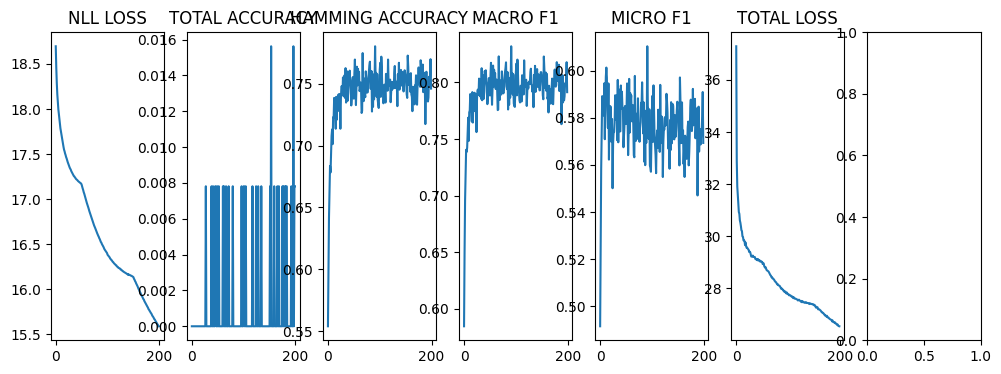

In [42]:
import matplotlib.pyplot as plt
# Create a figure with one row and four columns
fig, axes = plt.subplots(1, 7, figsize=(12, 4))  # Adjust figsize as needed
train_losses=torch.load('train_metrics_sider_200.pt')


# Plot each list in a separate subplot
axes[0].plot([i.item() for i in train_losses['nll_loss']])
axes[0].set_title('NLL LOSS')

axes[1].plot([i.item() for i in  train_losses['acc']])
axes[1].set_title('TOTAL ACCURACY')

axes[2].plot([i.item() for i in train_losses['hamm_acc']])
axes[2].set_title('HAMMING ACCURACY')

axes[3].plot([ i.item() for i in train_losses['macro_f1']])
axes[3].set_title('MACRO F1')

axes[4].plot([ i.item() for i in train_losses['micro_f1']])
axes[4].set_title('MICRO F1')

axes[5].plot([ i.item() for i in train_losses['total_loss']])
axes[5].set_title('TOTAL LOSS')

print(train_losses['auc'])
axes[6].plot([ i.item() for i in train_losses['auc']])
axes[6].set_title('AUC')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

AttributeError: 'int' object has no attribute 'item'

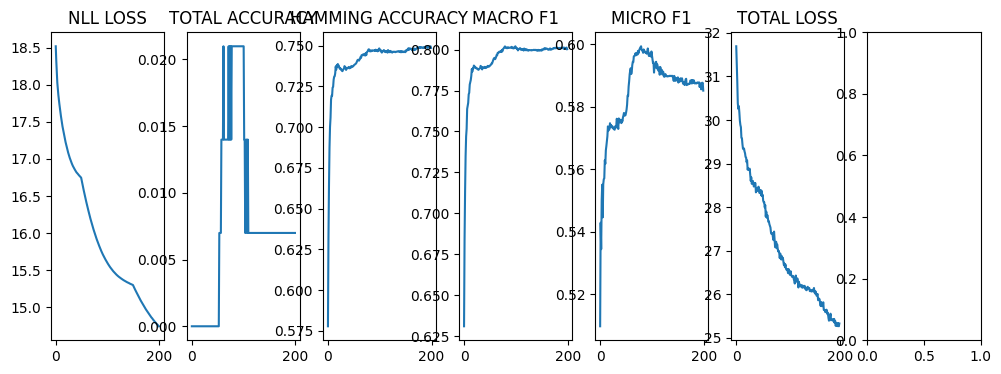

In [ ]:
import matplotlib.pyplot as plt
# Create a figure with one row and four columns
fig, axes = plt.subplots(1, 7, figsize=(12, 4))  # Adjust figsize as needed
train_losses=torch.load('test_metrics_sider_200.pt')


# Plot each list in a separate subplot
axes[0].plot([i.item() for i in train_losses['nll_loss']])
axes[0].set_title('NLL LOSS')

axes[1].plot([i.item() for i in  train_losses['acc']])
axes[1].set_title('TOTAL ACCURACY')

axes[2].plot([i.item() for i in train_losses['hamm_acc']])
axes[2].set_title('HAMMING ACCURACY')

axes[3].plot([ i.item() for i in train_losses['macro_f1']])
axes[3].set_title('MACRO F1')

axes[4].plot([ i.item() for i in train_losses['micro_f1']])
axes[4].set_title('MICRO F1')

axes[5].plot([ i.item() for i in train_losses['total_loss']])
axes[5].set_title('TOTAL LOSS')

axes[6].plot([ i.item() for i in train_losses['auc']])
axes[6].set_title('AUC')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
model=torch.load('model_sider_200.pt').to(device)
random=dataset.sample(n=1)

r=next(iter(test_loader))
r=r.to(device)
print('\n Actual Labels :',torch.tensor(list(random['labels'])))
total_loss, nll_loss, nll_loss_x, c_loss, c_loss_x, kl_loss, cpc_loss, _, pred_x = \
                    compute_loss(r[0].y,model(r[0].y,r[0]), args)
print('\n Predicted Labels:',torch.round(pred_x).to(torch.int))


 Actual Labels : tensor([[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
         1, 1, 0]])

 Predicted Labels: tensor([[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
         1, 1, 1]], device='cuda:0', dtype=torch.int32)


In [ ]:
from sklearn.metrics import auc,roc_auc_score
print(pred_x[0].tolist())
auROC = roc_auc_score(list(random['labels'])[0], pred_x[0].tolist())
print(auROC)

[0.5179914236068726, 0.610162615776062, 0.3123822510242462, 0.5453558564186096, 0.6320347785949707, 0.6084296107292175, 0.687676727771759, 0.3853939473628998, 0.5809288024902344, 0.5360583066940308, 0.40349051356315613, 0.6781104803085327, 0.3823017477989197, 0.3644939959049225, 0.6224645972251892, 0.5301380753517151, 0.6643182039260864, 0.33079826831817627, 0.5656139254570007, 0.6015693545341492, 0.6037715673446655, 0.5231702327728271, 0.31717875599861145, 0.49939456582069397, 0.5860010981559753, 0.6786187291145325, 0.5560771226882935]
0.9500000000000001


100%|██████████| 5/5 [00:00<00:00, 31.77it/s]

[[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]]
[[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]]
[[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]]
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]]
0.9090882538514118


In [ ]:
print(c)

5
